In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
from scipy import stats

import model
# import model as model
# %load_ext snakeviz
from collections import OrderedDict

In [2]:
params_super = {'patient0_hist':'equil', 'R0':2.0, 'delay':1, 'loss':0, 'iso_fac':0.1, 'test_fac':0.2}
params_fast = {'patient0_hist':'equil', 'R0':2.0, 'delay':24, 'loss':0.1, 'iso_fac':0.1, 'test_fac':0.2}
params_slow = {'patient0_hist':'equil', 'R0':2.0, 'delay':48, 'loss':0.1, 'iso_fac':0.1, 'test_fac':0.2}


params_super_nowalkin = {'patient0_hist':'equil', 'R0':2.0, 'delay':1, 'loss':0, 'iso_fac':0.1, 'test_fac':1e-6}
params_super_lockdown = {'patient0_hist':'equil', 'R0':1.1, 'delay':1, 'loss':0, 'iso_fac':0.1, 'test_fac':0.2}

params_exp = {'patient0_hist':'equil', 'R0':2.0, 'delay':0, 'loss':1, 'iso_fac':0.1, 'test_fac':1e-10}
tspan_days=30
params_super_lockdown = {'patient0_hist':'equil', 'R0':2.0, 'delay':0, 'loss':0, 'iso_fac':0.1, 'test_fac':0.2}

params = params_slow
params = params_exp
params = params_super_lockdown

## Test timing and saving results

In [33]:

# %%timeit

params_super_lockdown = {
    'patient0_hist':'equil', 'R0':2.0, 'delay':0, 
    'loss':0, 'iso_fac':0., 'test_fac':0.2}
tree = model.Tree(**params_super_lockdown)
tree.run_sim(tspan_days=tspan_days, verbose=True)
tree.totals['infected']

Starting simulation for 30.00 days

Schedule patient0 test for  0
0: ...run_Ts: T0 CT0->-3 (0) T-3 CT-3->0 (0)
146: R-3
274: R0


0

In [4]:
tree.G.number_of_nodes()

1

In [8]:
tree.G.nodes

NodeView((-4, 0, 3, 5))

## Run Multiple simulations

In [56]:



Ndraw = 500
active_hist = np.zeros((Ndraw, tspan_days*24))
infected_hist = np.zeros((Ndraw, tspan_days*24))
infected0 = np.zeros(Ndraw)

t = np.arange(tspan_days*24)/24

# tree = model.Tree(patient0_hist='none')
for ind in range(Ndraw):
    if ind%np.round(0.05*Ndraw)==0:
        print('progress = ', ind/Ndraw)
        
    tree = model.Tree(**params)
    tree.run_sim(tspan_days=tspan_days, verbose=False)
    
    infected0[ind] = tree._totals['hist_infected']
    active_hist[ind] = np.array(tree._totals_history['active'])
    infected_hist[ind] = np.array(tree._totals_history['infected'])

progress =  0.0


KeyboardInterrupt: 

In [471]:
all_infected_hist = (infected_hist.T+infected0-1).T

(0, 50)

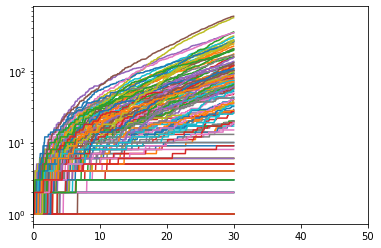

In [412]:
plt.figure()
plt.semilogy(t, infected_hist[mask_inactive,:].T, '-');

# plt.figure()
# plt.semilogy(t, all_infected_hist.T, '-');

plt.xlim(0,50)

In [424]:
mask_inactive = active_hist[:,-1]==0
frac_recov = np.mean(mask_inactive)
print('frac recovered = ', frac_recov)

frac recovered =  0.458


In [425]:
log_med = np.log10(np.median(all_infected_hist[~mask_inactive,-1]))
log_mean = np.mean(np.log10(all_infected_hist[~mask_inactive,-1]))
log_std = np.std(np.log10(all_infected_hist[~mask_inactive,-1]))

print('log_med  = ', log_med)
print('log_mean = ', log_mean)
print('log_std  = ', log_std)

log_med  =  1.7160033436347992
log_mean =  1.7037768653126415
log_std  =  0.34013822538624117


# Fast
* frac recovered =  0.294
* log_med  =  2.53655844257153
* log_mean =  2.512301094986658
* log_std  =  0.4648723849599155


# Slow
* frac recovered =  0.268
* log_med  =  2.819872821950546
* log_mean =  2.7590140366972435
* log_std  =  0.46605970918015227


In [460]:
tests_per_day = 1000
frac_positive = 0.2
lam=frac_positive*tests_per_day/24

In [472]:
# hourly_tests.sum()/tspan_days

infections = []

for t_hour in range(tspan_days*24):
    itest_num = np.random.poisson(lam=lam)
    rand_ind = np.floor(Ndraw*np.random.rand(itest_num)).astype(int)
    rand_infections = infected_hist[rand_ind, :]
    N_rand_infect = len(rand_infections)
    
    if t_hour>0:
        remaining_infections = rand_infections[:,:-t_hour]
    else:
        remaining_infections = rand_infections
        
    # print(remaining_infections.shape)
    # remaining_infections.shape
    added_infections = np.zeros((N_rand_infect, tspan_days*24))
    added_infections[:, t_hour:] = remaining_infections
    infections.append(added_infections)
    
infections = np.vstack(infections)

infections_tot = np.sum(infections, axis=0)
# infections_tot[:24]

/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


(0, 30)

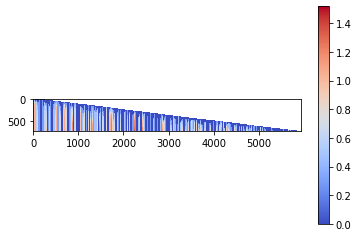

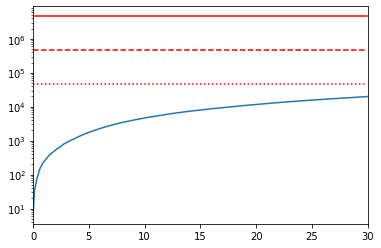

In [473]:
plt.figure()
plt.imshow(np.log10(infections.T),cmap='coolwarm')
plt.colorbar(label='log10(total infections)')


plt.figure()
plt.semilogy(t, infections_tot, '-')
plt.plot(t, 4.6e6*np.ones(t.size), 'r-')
plt.plot(t, 0.1*4.6e6*np.ones(t.size), 'r--')
plt.plot(t, 0.01*4.6e6*np.ones(t.size), 'r:')
plt.xlim(0,30)

In [435]:
infections_tot_super = infections_tot

In [463]:
infections_tot_super_nowalkin = infections_tot

In [474]:
infections_tot_super_lockdown = infections_tot

In [440]:
infections_tot_slow = infections_tot

In [445]:
infections_tot_fast = infections_tot

Text(0, 0.5, 'Total Infections')

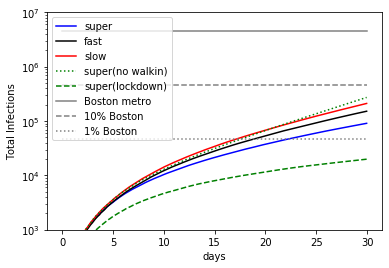

In [475]:
plt.figure()
plt.semilogy(t, infections_tot_super, 'b-', label='super')
plt.semilogy(t, infections_tot_fast, 'k-', label='fast')
plt.semilogy(t, infections_tot_slow, 'r-', label='slow')
plt.semilogy(t, infections_tot_super_nowalkin, 'g:', label='super(no walkin)')
plt.semilogy(t, infections_tot_super_lockdown, 'g--', label='super(lockdown)')
plt.plot(t, 4.6e6*np.ones(t.size), '-', color=[.5,.5,.5], label='Boston metro')
plt.plot(t, 0.1*4.6e6*np.ones(t.size), '--', color=[.5,.5,.5], label='10% Boston')
plt.plot(t, 0.01*4.6e6*np.ones(t.size), ':', color=[.5,.5,.5], label='1% Boston')
# plt.xlim(0,30)
plt.ylim(1e3, 1e7)
plt.legend(loc='upper left')

plt.xlabel('days')
plt.ylabel('Total Infections')

In [429]:
rand_ind = np.floor(Ndraw*np.random.rand(200)).astype(int)
np.sum(all_infected_hist[rand_ind,-1])/5e6

0.0015586

In [252]:
200*10**2.5/5e6

0.012649110640673518

In [220]:
mask_inactive = active_hist[:,-1]==0
frac_recov = np.mean(mask_inactive)
print('frac recovered = ', frac_recov)

frac recovered =  0.294


In [219]:
log_med = np.log10(np.median(all_infected_hist[~mask_inactive,-1]))
log_mean = np.mean(np.log10(all_infected_hist[~mask_inactive,-1]))
log_std = np.std(np.log10(all_infected_hist[~mask_inactive,-1]))

print('log_med  = ', log_med)
print('log_mean = ', log_mean)
print('log_std  = ', log_std)

log_med  =  2.53655844257153
log_mean =  2.512301094986658
log_std  =  0.4648723849599155


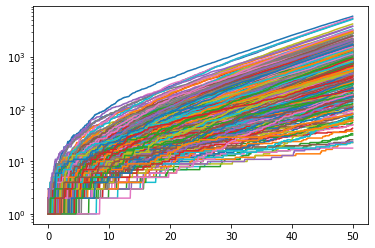

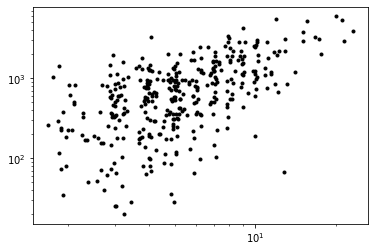

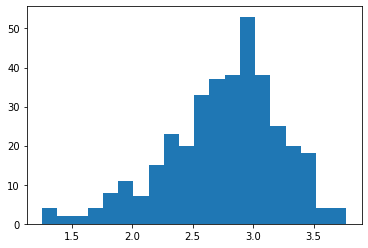

In [228]:
plt.figure()
plt.semilogy(t, infected_hist[~mask_inactive,:].T, '-');

plt.figure()
plt.loglog(infected0[~mask_inactive]+2e-1*np.random.randn((~mask_inactive).sum()), all_infected_hist[~mask_inactive,-1], 'ko', ms=3)

plt.figure()
plt.hist(np.log10(infected_hist[~mask_inactive,-1]),20);



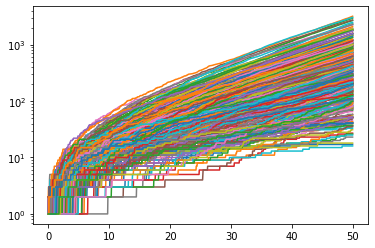

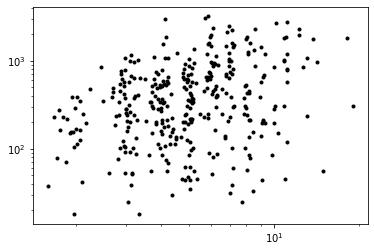

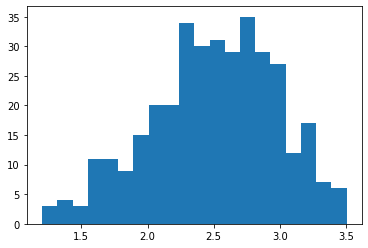

In [213]:
plt.figure()
plt.semilogy(t, infected_hist[~mask_inactive,:].T, '-');

plt.figure()
plt.loglog(infected0[~mask_inactive]+2e-1*np.random.randn((~mask_inactive).sum()), all_infected_hist[~mask_inactive,-1], 'ko', ms=3)

plt.figure()
plt.hist(np.log10(infected_hist[~mask_inactive,-1]),20);



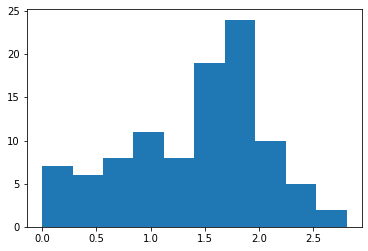

In [186]:
plt.hist(np.log10(infected_hist[:,-600]),10);

1200


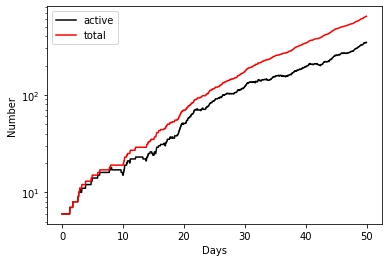

In [150]:
infected0 = tree._totals['hist_infected']

active_hist = np.array(tree._totals_history['active'])
infected_hist = np.array(tree._totals_history['infected'])
t = np.arange(active_hist.size)/24
print(len(t))

plt.figure()
plt.semilogy(t, active_hist, 'k-', label='active')
plt.semilogy(t, infected_hist+infected0-1, 'r-', label='total')
# plt.semilogy(t, infected0*np.exp(k*t), 'r--')

plt.xlabel('Days')
plt.ylabel('Number')
plt.legend()

In [2]:
def store_stats(avg, std):
    stats = {}
    stats['avg'] = np.array(avg)
    stats['std'] = np.array(std)
    return stats

In [3]:
def get_equil_stats():
    stats = {}
    stats['total'] = store_stats([6.89, 5.11, 4.49, 3.30], 
                                 [2.18, 2.29, 2.19, 1.88])
    stats['active'] = store_stats([6.53, 4.38, 3.58, 2.02], 
                                  [2.38, 2.69, 2.66, 2.27])
    return stats

def get_legacy_stats():
    stats = {}
    stats['total'] = store_stats([4.71, 3.77, 3.43, 2.93], 
                                 [2.64, 2.25, 2.08, 1.81])
    stats['active'] = store_stats([4.21, 2.94, 2.49, 1.72], 
                                  [2.94, 2.61, 2.43, 2.10])
    return stats

In [4]:
all_stats = {}
all_stats['equil'] = get_equil_stats()
all_stats['legacy'] = get_legacy_stats()
all_stats

{'equil': {'active': {'avg': array([6.53, 4.38, 3.58, 2.02]),
   'std': array([2.38, 2.69, 2.66, 2.27])},
  'total': {'avg': array([6.89, 5.11, 4.49, 3.3 ]),
   'std': array([2.18, 2.29, 2.19, 1.88])}},
 'legacy': {'active': {'avg': array([4.21, 2.94, 2.49, 1.72]),
   'std': array([2.94, 2.61, 2.43, 2.1 ])},
  'total': {'avg': array([4.71, 3.77, 3.43, 2.93]),
   'std': array([2.64, 2.25, 2.08, 1.81])}}}

In [5]:
equil_avg = all_stats['equil']['total']['avg']
legacy_avg = all_stats['legacy']['total']['avg']

def contact_tracing_effect(avg):
    ct_effect_bnds = np.array([avg[2], avg[0]])
    delay_effect_bnds = np.array([avg[2], avg[1]])
    
    return ct_effect_bnds, delay_effect_bnds

equil_ct_effect_bnds, equil_delay_effect_bnds = contact_tracing_effect(equil_avg)
legacy_ct_effect_bnds, legacy_delay_effect_bnds = contact_tracing_effect(legacy_avg)

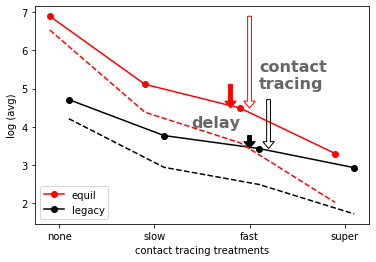

In [6]:
plt.figure()
run_id = np.arange(4)


plt.plot(run_id-.1, all_stats['equil']['total']['avg'], 'ro-', label='equil')
plt.plot(run_id+.1, all_stats['legacy']['total']['avg'], 'ko-', label='legacy')

plt.plot(run_id-.1, all_stats['equil']['active']['avg'], 'r--', label='')
plt.plot(run_id+.1, all_stats['legacy']['active']['avg'], 'k--', label='')

ax = plt.gca()
ax.set_xticks(run_id)
ax.set_xticklabels(['none','slow','fast','super'])



plt.text(2.1,5.0,'contact\ntracing', fontweight='bold', 
         fontsize=16, color=[.4,.4,.4])
plt.arrow(2.0,equil_ct_effect_bnds[1],0,-np.diff(equil_ct_effect_bnds)[0], 
          width=.04, facecolor='none', edgecolor='r', length_includes_head=True)

plt.text(1.9,4.0,'delay', horizontalalignment='right', fontweight='bold', 
         fontsize=16, color=[.4,.4,.4])

plt.arrow(2.2,legacy_ct_effect_bnds[1],0,-np.diff(legacy_ct_effect_bnds)[0], 
          width=.04, facecolor='none', edgecolor='k', length_includes_head=True)


plt.arrow(1.8, equil_delay_effect_bnds[1],0,-np.diff(equil_delay_effect_bnds)[0], 
          width=.04, color='r', length_includes_head=True)

plt.arrow(2.0, legacy_delay_effect_bnds[1],0,-np.diff(legacy_delay_effect_bnds)[0], 
          width=.04, color='k', length_includes_head=True)

plt.ylabel('log (avg)')
plt.xlabel('contact tracing treatments')
plt.legend(loc='lower left')

In [8]:
tree._totals_history

{'infected': [13, 12], 'spontaneous': [1, 2], 'tested': [1, 1, 2, 3, 3, 3]}

In [5]:
print(tree.totals)

{'hist_infected': 14, 'infected': 82, 'spontaneous': 5, 'tested': 37, 'active': 79}


In [2]:
tree = model.Tree.get_equil_infection_hist(R0=2)
G = tree.G

In [3]:
def get_equil_infection_hist(relabel=True, **kwargs): 
    while True:
        tree = model.Tree(test_fac=0, **kwargs)
        tree.run_sim(tspan_days=tree.DURATION/24+1, verbose=False)
        tree.totals
        if tree.totals['active']==0:
            continue
            
        tree = expand_to_patient0(tree)
        if tree is None:
            continue
        else:
            break
            
    # print('totals = ', tree.totals)
    # print('clock = ', tree._clock)
        
    # print('totals = ', tree.totals)
    # print('clock = ', tree._clock)
    
    if relabel:
        G = tree.G
        node_ids0= np.array(G.nodes)
        # print(node_ids0)
        # print(node_ids0)
        node_remap = dict(zip(node_ids0, node_ids0-node_ids0.size+1))
        # print(node_remap)
        
        # NOTE: do NOT use copy=False... there is a bug that reorders nodes
        H = nx.relabel_nodes(G, node_remap, copy=True)
        tree._G = H
    
    # ancestor0 = -node_ids0.size+1
    # print(ancestor0)
    
    # Now prune out inaccesibile cases to contact tracing
    # G.nodes[0]
    # init_case = list(tree.G.nodes)[0]
    # G.remove_node(init_case)
    
    return tree

def expand_to_patient0(tree):
    infected0 = tree.totals['infected']
    infected = infected0
    
    while infected==infected0:
        tree.run_sim(tspan_days=1/24, verbose=False)
        infected = tree.totals['infected']
        active = tree.totals['active']
        if active==0:
            return None
            
    return tree



def get_ancestor_root(tree):
    G = tree.G
    
    Nnode = G.number_of_nodes()
    recovered = np.tile(False, Nnode)
    node_ids = np.zeros(Nnode, dtype=int)
    for inode, irecov in G.nodes(data='recovered'):
        ind = inode+Nnode-1
        node_ids[ind] = inode
        recovered[ind] = irecov
        
    #print(recovered)
    #print(node_ids)
    recovered_nodes = node_ids[recovered]
    # print(recovered_nodes)
    
    
    branch_roots = []
    for inode in recovered_nodes:
        ineigh = list(nx.neighbors(G, inode))
        unrecovered_neigh = [ind for ind in ineigh if ind not in recovered_nodes]
        branch_roots.extend(unrecovered_neigh)
        
    branch_roots = np.array(branch_roots)
    # print(branch_roots)
    
    mask = np.array([0 in nx.descendants(G, i) for i in branch_roots])
    ancestor_root = branch_roots[mask][0]
    
    
    
    return ancestor_root, recovered_nodes


##################

def prune_ancestor_root(tree, ancestor_root, recovered_nodes):
    G = tree.G
    nodes = list(nx.descendants(G, ancestor_root))+[ancestor_root]
    
    pruned_nodes = [i for i in G.nodes if i not in nodes]
    pruned_active_nodes = [i for i in pruned_nodes if i not in recovered_nodes]
    if len(pruned_active_nodes)==0:
        pruned_active_nodes = None
    
    
    pruned_G = nx.subgraph(G, nodes)
    
    return pruned_G, pruned_active_nodes


In [5]:

def draw_infect_hist(G, pruned_active_nodes=None):
    t_infect = [t for (ind, t) in list(G.nodes(data='t_infect'))]
    
    node_id_dat = list(G.nodes(data='recovered'))
                       
    node_ids0= np.array(G.nodes)
    rec0 = np.array([rec for (i,rec) in G.nodes(data='recovered')])

    ind_sort = np.argsort(node_ids0)
    node_ids = node_ids0[ind_sort]

    recovered = rec0[ind_sort]
    active = -2*recovered
    active[-1] = +2

    if pruned_active_nodes is not None:
        pruned_active_ind = np.array(pruned_active_nodes)-1
        active[pruned_active_ind] = -1
                       
                       
    # active = -2.0*np.array([rec for (ind, rec) in list(G.nodes(data='recovered'))])
    #                    
    # for (ind, rec) in node_ids:
    #     print()
    # active = -2.0*np.array([rec for (ind, rec) in list(G.nodes(data='recovered'))])
    # active[-1] = +2
    # 
    # if pruned_active_nodes is not None:
    #     print([ind for (ind, rec) in list(G.nodes(data='recovered'))]    )
    #     active[np.array(pruned_active_nodes)-1] = -1
    
    plt.figure()
    nx.draw_networkx(G, node_color=active, cmap='coolwarm_r', vmin=-2, vmax=+2)
    
    # plt.figure()
    # nx.draw_networkx(G, node_color=t_infect, cmap='Wistia_r')

In [9]:
tree = model.Tree(patient0_hist='none')
tree.run_sim(tspan_days=30, verbose=False)
G = tree.G

nodes:  [0]
curr node:  1


In [18]:
[node for node in G.nodes]

[0, 1]

In [3]:

# tree = get_equil_infection_hist(R0=2)
# G = tree.G
# ancestor_root, recovered_nodes  = get_ancestor_root(tree)
# print('ancestor_root = ', ancestor_root)
# G_prune, pruned_active_nodes = prune_ancestor_root(tree, ancestor_root, recovered_nodes)

tree = model.Tree.get_equil_infection_hist(R0=3)
G = tree.G

ancestor_root, recovered_nodes  = model.Tree.get_ancestor_root(tree)
G_prune, pruned_active_nodes = model.Tree.prune_ancestor_root(tree, ancestor_root, recovered_nodes)


nodes:  [0]
curr node:  1
t_patient0 update =  {'t_infect': 0, 'recovered': False, 'isolated': False}


In [4]:
G_prune.number_of_nodes()

14

In [5]:
G_prune.nodes()

NodeView((-19, -16, -15, -14, -13, -10, -9, -7, -6, -5, -4, -3, -2, 0))

In [6]:
G_prune.add_node(1, t_infect=0, recovered=False, isolated=False)

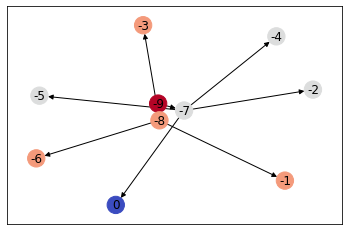

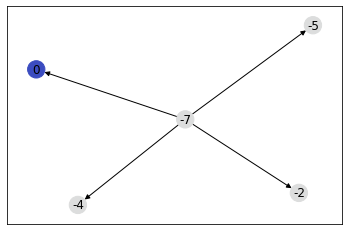

In [14]:
# 
draw_infect_hist(tree.G, pruned_active_nodes=pruned_active_nodes)
draw_infect_hist(G_prune)
# plt.figure()
# nx.draw_networkx(G_prune)

In [33]:
R_test = model.Tree().R_test
R_test_norm = R_test/R_test.sum()
R_test_cum = np.cumsum(R_test_norm)

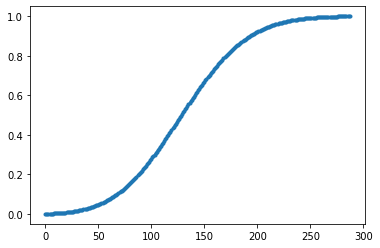

In [36]:
plt.figure()
plt.plot(R_test_cum, '.-')

In [46]:
ind = np.where(np.random.rand()< R_test_cum)[0][0]
print(ind)

76
